# Experiments with Lamarckism

This notebook as a couple of experiments around the idea of adding layers to an existing model and then train it some more in hopes this will improve the accuracy of the model. 

The experiments are borrowed from [this blogpost](https://myrtle.ai/how-to-train-your-resnet-4-architecture/) ([notebook](https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb)) in which the author sets out to achieve 94% accuracy on CIFAR10 in as short time as possible. Apart from the overall usefulness of fast training, the experiments feature a backbone model which achieves just over 90% accuracy which is then enhanced with a few more layers to achive 94% accuracy when trained from scratch.

This will serve as a baseline for the experiments in this notebook. Instead of creating a new model from scratch, we here will try to add the extra layers to an already trained backbone model and then try to train it to achive the same accuracy as if the larger model was fully trained from scratch.

Summary of experiments is that things are a bit less straightforward than I though, but the concept seems to be useful. It is quite difficult to improve a converged model without any temporary decrease in accuracy, but if the changes are made before the model has converged it seems to have less impact.

This could indicate that some kind of annealing of the mutation rate is useful, or else almost converged models might see too much perturbation to converge efficiently. 

This is a bit unfortunate as it brings in a need to determine whether models have converged or not and this might not be easy to do well without prior knowledge of how fitting a particular data set plays out.

Another learning is that it seems to be important to keep the learning rate relatively high, possibly as this pushes the model out of whatever low loss region it is in to somewhere else where the new layers are actually used for something.

Stay tuned for when some other data set or training method completely invalidates everything in this notebook! :)

In [1]:
include("src/Lamarckism.jl");
using Flux
using Flux.Optimise
using ONNXmutable
using Random
using Plots


┌ Info: Precompiling NaiveGAflux [81ede08e-ab29-11e9-16d3-79edd30a1d76]
└ @ Base loading.jl:1273
┌ Info: Precompiling Augmentor [02898b10-1f73-11ea-317c-6393d7073e15]
└ @ Base loading.jl:1273
┌ Info: Precompiling ONNXmutable [cf2a63a0-f8ae-421c-82b7-306ecfceaf66]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



## Train the backbone model
Train the backbone model from the blog post which achieves 91.1% accuracy. This model will be reused in subsequent experiments.

In [2]:
Random.seed!(1)
nepochs = 20

lrs = Lamarckism.lrsched(nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    # Reference experiment does this thing where it divides the learning rate and multiplies the weight decay with batchsize
    # These should cancel each other out in the end
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end

accuracy_backbone, model_backbone = Lamarckism.train(Lamarckism.backbone(), nepochs, optf);


Epoch 1,	lr: 0.1,	test accuracy: 0.3707
Epoch 2,	lr: 0.2,	test accuracy: 0.5284
Epoch 3,	lr: 0.3,	test accuracy: 0.6477
Epoch 4,	lr: 0.4,	test accuracy: 0.5852
Epoch 5,	lr: 0.375,	test accuracy: 0.6779
Epoch 6,	lr: 0.35,	test accuracy: 0.6825
Epoch 7,	lr: 0.325,	test accuracy: 0.7196
Epoch 8,	lr: 0.3,	test accuracy: 0.7275
Epoch 9,	lr: 0.275,	test accuracy: 0.7527
Epoch 10,	lr: 0.25,	test accuracy: 0.7243
Epoch 11,	lr: 0.225,	test accuracy: 0.7849
Epoch 12,	lr: 0.2,	test accuracy: 0.8187
Epoch 13,	lr: 0.175,	test accuracy: 0.8081
Epoch 14,	lr: 0.15,	test accuracy: 0.8206
Epoch 15,	lr: 0.125,	test accuracy: 0.8155
Epoch 16,	lr: 0.1,	test accuracy: 0.8246
Epoch 17,	lr: 0.075,	test accuracy: 0.8403
Epoch 18,	lr: 0.05,	test accuracy: 0.8689
Epoch 19,	lr: 0.025,	test accuracy: 0.8822
Epoch 20,	lr: 0.0,	test accuracy: 0.8877


A few % off compared to the reference experiments, but hopefully the difference between models stays the same so comparison is still possible. 

Save the model so it can be reused without having to retrain it between sessions:

In [3]:
onnx("pretrained/backbone.onnx",model_backbone, (32,32,3,:B));

## Train the resnet model
This is the same resnet as used in the blog post.

In [4]:
Random.seed!(1)
nepochs = 20
batchsize = 512

lrs = Lamarckism.lrsched(nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    # Reference experiment does this thing where it divides the learning rate and multiplies the weight decay with batchsize
    # These should cancel each other out in the end
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end

accuracy_resnet, model_resnet = Lamarckism.train(Lamarckism.resnet(), nepochs, optf);

Epoch 1,	lr: 0.1,	test accuracy: 0.4701
Epoch 2,	lr: 0.2,	test accuracy: 0.5743
Epoch 3,	lr: 0.3,	test accuracy: 0.6658
Epoch 4,	lr: 0.4,	test accuracy: 0.6744
Epoch 5,	lr: 0.375,	test accuracy: 0.6691
Epoch 6,	lr: 0.35,	test accuracy: 0.7657
Epoch 7,	lr: 0.325,	test accuracy: 0.7966
Epoch 8,	lr: 0.3,	test accuracy: 0.7854
Epoch 9,	lr: 0.275,	test accuracy: 0.8018
Epoch 10,	lr: 0.25,	test accuracy: 0.7945
Epoch 11,	lr: 0.225,	test accuracy: 0.763
Epoch 12,	lr: 0.2,	test accuracy: 0.8265
Epoch 13,	lr: 0.175,	test accuracy: 0.8304
Epoch 14,	lr: 0.15,	test accuracy: 0.854
Epoch 15,	lr: 0.125,	test accuracy: 0.8422
Epoch 16,	lr: 0.1,	test accuracy: 0.8619
Epoch 17,	lr: 0.075,	test accuracy: 0.8857
Epoch 18,	lr: 0.05,	test accuracy: 0.9068
Epoch 19,	lr: 0.025,	test accuracy: 0.9152
Epoch 20,	lr: 0.0,	test accuracy: 0.9205


Save this model too:

In [5]:
onnx("pretrained/resnet.onnx",model_resnet, (32,32,3,:B));

## Experiment 1: Impact of identity weight initialization
Adding layers to a model typically results in a large degradation in accuracy. This is of course not ideal if one wants to quickly assess if the new model is an improvement over the existing one. 

One way to prevent this drop is to initialize new layers with an identity mapping. For layers in a residual block this can be achieved by initializing all weights to zero, but this will make the gradient zero as well, preventing any further training of the new weights. 

Instead, the new layers are initialized with an identity mapping so that they output their input and then scale the output of each resblock with a factor of 0.5. 

In this experiment, a completely fresh backbone model will be used (i.e not the one trained above). Before any training takes place, two identity mapping residual blocks will be added to it, making its architecture identical to the resnet in the previous example.

Question is: Does having parts of the model having a "suboptimal" weight initializtion hurt the final performance?


In [6]:
Random.seed!(1)
nepochs = 20

lrs = Lamarckism.lrsched(nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    # Reference experiment does this thing where it divides the learning rate and multiplies the weight decay with batchsize
    # These should cancel each other out in the end
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end

model_backbone_add_resblocks, newpars = Lamarckism.addres_fixed(Lamarckism.backbone(), [6,12]);
@show unique.(newpars)

accuracy_backbone_add_resblocks, model_backbone_add_resblocks = Lamarckism.train(model_backbone_add_resblocks, nepochs, optf);

unique.(newpars) = Array{Float32,1}[[0.0, 1.0], [0.0], [1.0], [0.0, 1.0], [0.0], [1.0], [0.0, 1.0], [0.0], [1.0], [0.0, 1.0], [0.0], [1.0]]
Epoch 1,	lr: 0.1,	test accuracy: 0.4277
Epoch 2,	lr: 0.2,	test accuracy: 0.6049
Epoch 3,	lr: 0.3,	test accuracy: 0.6713
Epoch 4,	lr: 0.4,	test accuracy: 0.6173
Epoch 5,	lr: 0.375,	test accuracy: 0.6916
Epoch 6,	lr: 0.35,	test accuracy: 0.7204
Epoch 7,	lr: 0.325,	test accuracy: 0.7705
Epoch 8,	lr: 0.3,	test accuracy: 0.7598
Epoch 9,	lr: 0.275,	test accuracy: 0.8285
Epoch 10,	lr: 0.25,	test accuracy: 0.7858
Epoch 11,	lr: 0.225,	test accuracy: 0.8249
Epoch 12,	lr: 0.2,	test accuracy: 0.7584
Epoch 13,	lr: 0.175,	test accuracy: 0.835
Epoch 14,	lr: 0.15,	test accuracy: 0.8256
Epoch 15,	lr: 0.125,	test accuracy: 0.8642
Epoch 16,	lr: 0.1,	test accuracy: 0.875
Epoch 17,	lr: 0.075,	test accuracy: 0.8759
Epoch 18,	lr: 0.05,	test accuracy: 0.9053
Epoch 19,	lr: 0.025,	test accuracy: 0.9194
Epoch 20,	lr: 0.0,	test accuracy: 0.9214


Not alot apparently! It seems like having some layers with identity mapping weights does not hurt the final model performance.

Lets save this model and plot the accuracy per epoch for each model:

In [7]:
onnx("pretrained/backbone_add_resblocks.onnx",model_backbone_add_resblocks, (32,32,3,:B));

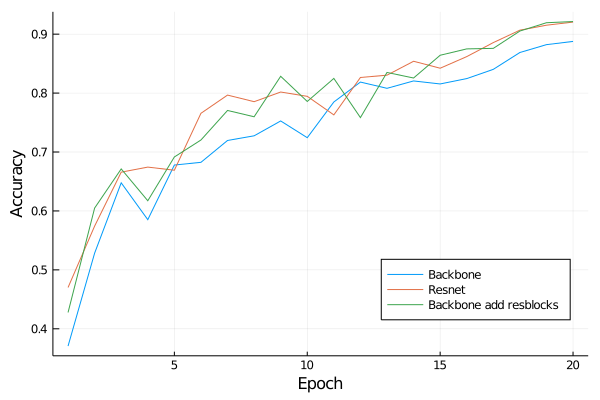

In [8]:
plot(accuracy_backbone, label="Backbone");
plot!(accuracy_resnet, label="Resnet");
plot!(accuracy_backbone_add_resblocks, label="Backbone add resblocks", xlabel="Epoch", ylabel="Accuracy", legend=:bottomright)

View models using [netron](https://lutzroeder.github.io/netron):<br>
[backbone](https://lutzroeder.github.io/netron?url=https://github.com/DrChainsaw/NaiveGAExperiments/blob/master/lamarckism/pretrained/backbone.onnx)<br>
[resnet](https://lutzroeder.github.io/netron?url=https://github.com/DrChainsaw/NaiveGAExperiments/blob/master/lamarckism/pretrained/resnet.onnx)<br>
[backbone with added resblocks](https://lutzroeder.github.io/netron?url=https://github.com/DrChainsaw/NaiveGAExperiments/blob/master/lamarckism/pretrained/backbone_add_resblocks.onnx)

## Experiment 2: Fully retrain a pretrained model

Now lets see what happens if the already trained backbone model is transformed to a resnet and then re-trained using the same number of epochs and learning rate schedule as the resnet.

In [9]:
Random.seed!(1)
nepochs = 20

lrs = Lamarckism.lrsched(nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end
    
model, newpars = Lamarckism.addres_fixed(Lamarckism.pretrained("pretrained/backbone.onnx"), [6,12]);
@show unique.(newpars)
    
Lamarckism.train(model, nepochs, optf);

unique.(newpars) = Array{Float32,1}[[0.0, 1.0], [0.0], [1.0], [0.0, 1.0], [0.0], [1.0], [0.0, 1.0], [0.0], [1.0], [0.0, 1.0], [0.0], [1.0]]
Epoch 1,	lr: 0.1,	test accuracy: 0.823
Epoch 2,	lr: 0.2,	test accuracy: 0.7854
Epoch 3,	lr: 0.3,	test accuracy: 0.7742
Epoch 4,	lr: 0.4,	test accuracy: 0.6869
Epoch 5,	lr: 0.375,	test accuracy: 0.7344
Epoch 6,	lr: 0.35,	test accuracy: 0.7412
Epoch 7,	lr: 0.325,	test accuracy: 0.7471
Epoch 8,	lr: 0.3,	test accuracy: 0.7949
Epoch 9,	lr: 0.275,	test accuracy: 0.8357
Epoch 10,	lr: 0.25,	test accuracy: 0.8496
Epoch 11,	lr: 0.225,	test accuracy: 0.8391
Epoch 12,	lr: 0.2,	test accuracy: 0.8689
Epoch 13,	lr: 0.175,	test accuracy: 0.8323
Epoch 14,	lr: 0.15,	test accuracy: 0.8487
Epoch 15,	lr: 0.125,	test accuracy: 0.8785
Epoch 16,	lr: 0.1,	test accuracy: 0.878
Epoch 17,	lr: 0.075,	test accuracy: 0.8904
Epoch 18,	lr: 0.05,	test accuracy: 0.9192
Epoch 19,	lr: 0.025,	test accuracy: 0.9281
Epoch 20,	lr: 0.0,	test accuracy: 0.9321


We are able to reach the same performance as the resnet which is good. The transformed model starts out having much better accuracy than a randomly initialized model, but it takes a substantial hit in performance after the first epoch and after a few epochs the accuracy basically follows the same evolution as when a randomly initialized resnet is trained. 

Is it possible to do better?

## Experiment 3: Fine tune a pretrained model
In this experiment the pretrained backbone is again transformed to the resnet. As the goal is to fine tune the new layers one valid assumption is to start off with a lower learning rate.

As seen in experiment 2, a learning rate of 0.1 was detrimental to the performance. One can also see that after the learning rate hits 0.075 the accuracy starts to improve beyond what the backbone model achieved.

As such, lets try to fine tune the pretrained model for a generous 5 epochs starting with a learning rate of 0.05, linearly decreasing it to 0.0.

In [10]:
Random.seed!(1)
nepochs = 5

lrs = range(0.05,0.0, length=nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end
    
model, newpars = Lamarckism.addres_fixed(Lamarckism.pretrained("pretrained/backbone.onnx"), [6,12]);
    
Lamarckism.train(model, nepochs, optf);

Epoch 1,	lr: 0.05,	test accuracy: 0.8539
Epoch 2,	lr: 0.0375,	test accuracy: 0.8626
Epoch 3,	lr: 0.025,	test accuracy: 0.8842
Epoch 4,	lr: 0.0125,	test accuracy: 0.8919
Epoch 5,	lr: 0.0,	test accuracy: 0.8951


The drop in accuracy is not as severe, but it is still significant. Also, it did also not reach the same accuracy in the end.

Lets apply the same principle again: Model accuracy starts beating the baseline at learning rate of 0.025. Lets try to start from there. Also do more epochs to see if it is possible to reach same accuracy if the model is trained longer.

In [11]:
Random.seed!(1)
nepochs = 10

lrs = range(0.025,0.0, length=nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end
    
model, newpars = Lamarckism.addres_fixed(Lamarckism.pretrained("pretrained/backbone.onnx"), [6,12]);
    
Lamarckism.train(model, nepochs, optf);

Epoch 1,	lr: 0.025,	test accuracy: 0.8754
Epoch 2,	lr: 0.0222,	test accuracy: 0.8723
Epoch 3,	lr: 0.0194,	test accuracy: 0.889
Epoch 4,	lr: 0.0167,	test accuracy: 0.8873
Epoch 5,	lr: 0.0139,	test accuracy: 0.8914
Epoch 6,	lr: 0.0111,	test accuracy: 0.8897
Epoch 7,	lr: 0.00833,	test accuracy: 0.8986
Epoch 8,	lr: 0.00556,	test accuracy: 0.9002
Epoch 9,	lr: 0.00278,	test accuracy: 0.9005
Epoch 10,	lr: 0.0,	test accuracy: 0.9005


Not too bad! The model accuracy did not drop significantly but the training was slow and in the end we could not match the accuracy of the scratch trained resnet. 

Perhaps the reason was the extremely low learning rates for most of the training which without any built up momentum were just not sufficient to push the model to a better spot.

Lets try to keep the learning rate constant and see where we end up.

In [12]:
Random.seed!(1)
nepochs = 10

opt = Optimiser(WeightDecay(5f-4), Momentum(0.025f0, 0.9f0))
optf(e) = opt

model, newpars = Lamarckism.addres_fixed(Lamarckism.pretrained("pretrained/backbone.onnx"), [6,12]);
    
Lamarckism.train(model, nepochs, optf);

Epoch 1,	lr: 0.025,	test accuracy: 0.8741
Epoch 2,	lr: 0.025,	test accuracy: 0.873
Epoch 3,	lr: 0.025,	test accuracy: 0.8811
Epoch 4,	lr: 0.025,	test accuracy: 0.8763
Epoch 5,	lr: 0.025,	test accuracy: 0.8779
Epoch 6,	lr: 0.025,	test accuracy: 0.8643
Epoch 7,	lr: 0.025,	test accuracy: 0.8748
Epoch 8,	lr: 0.025,	test accuracy: 0.8916
Epoch 9,	lr: 0.025,	test accuracy: 0.8859
Epoch 10,	lr: 0.025,	test accuracy: 0.8981


That did not really take us anywhere either. Perhaps some more elaborate learning rate schedule will, but this needs to work without carefully tuned hyperparameters. Lets try something else...

## Experiment 4: Boost learning rate of new parameters
One attractive thought about adding identity layers is that the new layers just fill in what is missing from the already existing layers. While it is common practice to freeze layers when fine-tuning in a transfer learning context, the evolutionary architecture search which is the motivation for this work needs to work on models which have not yet converged.

As a middle road, lets try to boost the learning rate of the new parameters while keeping it small for the existing ones.

In [13]:
Random.seed!(1)
nepochs = 10

lrs = range(0.025,0.0, length=nepochs)
opt = Momentum(0.1f0, 0.9f0)

model, newpars = Lamarckism.addres_fixed(Lamarckism.pretrained("pretrained/backbone.onnx"), [6,12]);
function optf(e)
    opt.eta = lrs[e]
    # Use 10 times higher learning rate for new parameters
    boost_new = Lamarckism.BoostPars(10.0, keys(IdDict(newpars .=> 1))) # Just a clumsy way of creating an IdSet...
    Optimiser(boost_new, WeightDecay(5f-4), opt)
end
    
 
Lamarckism.train(model, nepochs, optf);

Epoch 1,	lr: 0.025,	test accuracy: 0.8745
Epoch 2,	lr: 0.0222,	test accuracy: 0.8757
Epoch 3,	lr: 0.0194,	test accuracy: 0.8874
Epoch 4,	lr: 0.0167,	test accuracy: 0.8827
Epoch 5,	lr: 0.0139,	test accuracy: 0.8923
Epoch 6,	lr: 0.0111,	test accuracy: 0.8887
Epoch 7,	lr: 0.00833,	test accuracy: 0.8983
Epoch 8,	lr: 0.00556,	test accuracy: 0.8998
Epoch 9,	lr: 0.00278,	test accuracy: 0.9012
Epoch 10,	lr: 0.0,	test accuracy: 0.902


I'm kinda glad this did not work well as it would be a bit painful to implement in NaiveGAflux.

## Experiment 5: Add layers before training is complete
In this experiement the backbone is trained for 5 epochs after which it is transformed into the resnet and trained for 15 more epochs in order to more closely model how things would look "in the wild". 

The same learning rate schedule as used initially is used throughout the training.

In [2]:
Random.seed!(1)
nepochs = 20

lrs = Lamarckism.lrsched(nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end

nepochs_first = 5
accuracy, model = Lamarckism.train(Lamarckism.backbone(), nepochs_first, optf);

model, newpars = Lamarckism.addres_fixed(model, [6,12]);

accuracy, model = Lamarckism.train(model, nepochs - nepochs_first, e -> optf(e + nepochs_first));

Epoch 1,	lr: 0.1,	test accuracy: 0.3808
Epoch 2,	lr: 0.2,	test accuracy: 0.5385
Epoch 3,	lr: 0.3,	test accuracy: 0.6074
Epoch 4,	lr: 0.4,	test accuracy: 0.6524
Epoch 5,	lr: 0.375,	test accuracy: 0.6874
Epoch 1,	lr: 0.35,	test accuracy: 0.6968
Epoch 2,	lr: 0.325,	test accuracy: 0.7413
Epoch 3,	lr: 0.3,	test accuracy: 0.7693
Epoch 4,	lr: 0.275,	test accuracy: 0.7864
Epoch 5,	lr: 0.25,	test accuracy: 0.774
Epoch 6,	lr: 0.225,	test accuracy: 0.6043
Epoch 7,	lr: 0.2,	test accuracy: 0.8232
Epoch 8,	lr: 0.175,	test accuracy: 0.83
Epoch 9,	lr: 0.15,	test accuracy: 0.8603
Epoch 10,	lr: 0.125,	test accuracy: 0.8345
Epoch 11,	lr: 0.1,	test accuracy: 0.8538
Epoch 12,	lr: 0.075,	test accuracy: 0.888
Epoch 13,	lr: 0.05,	test accuracy: 0.9025
Epoch 14,	lr: 0.025,	test accuracy: 0.9092
Epoch 15,	lr: 0.0,	test accuracy: 0.9195


Basically no impact on final accuracy! 

That big drop in accuracy at epoch 6 is a bit worrying though as it could easily lead to the model being discarded. It could be just normal training noise, but it looks bigger than anything encountered before. 

Lets see what happens the resblocks are added one by one at different epochs:

In [3]:
Random.seed!(1)
nepochs = 20

lrs = Lamarckism.lrsched(nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end

accuracy, model = Lamarckism.train(Lamarckism.backbone(), 5, optf);

model, newpars = Lamarckism.addres_fixed(model, [12]);

accuracy, model = Lamarckism.train(model, 5, e -> optf(e + 5));

model, newpars = Lamarckism.addres_fixed(model, [6]);

accuracy, model = Lamarckism.train(model, 10, e -> optf(e + 10));

Epoch 1,	lr: 0.1,	test accuracy: 0.3606
Epoch 2,	lr: 0.2,	test accuracy: 0.5932
Epoch 3,	lr: 0.3,	test accuracy: 0.5659
Epoch 4,	lr: 0.4,	test accuracy: 0.6504
Epoch 5,	lr: 0.375,	test accuracy: 0.5672
Epoch 1,	lr: 0.35,	test accuracy: 0.7008
Epoch 2,	lr: 0.325,	test accuracy: 0.6895
Epoch 3,	lr: 0.3,	test accuracy: 0.7082
Epoch 4,	lr: 0.275,	test accuracy: 0.7521
Epoch 5,	lr: 0.25,	test accuracy: 0.781
Epoch 1,	lr: 0.225,	test accuracy: 0.8096
Epoch 2,	lr: 0.2,	test accuracy: 0.8236
Epoch 3,	lr: 0.175,	test accuracy: 0.8353
Epoch 4,	lr: 0.15,	test accuracy: 0.8311
Epoch 5,	lr: 0.125,	test accuracy: 0.8387
Epoch 6,	lr: 0.1,	test accuracy: 0.8516
Epoch 7,	lr: 0.075,	test accuracy: 0.8856
Epoch 8,	lr: 0.05,	test accuracy: 0.8965
Epoch 9,	lr: 0.025,	test accuracy: 0.9137
Epoch 10,	lr: 0.0,	test accuracy: 0.916


This seems to work as well!

This run did not display the same big drop in accuracy, but it is not possible to say if this is because we did smaller changes or if it is just happened randomly from just two single runs. I guess doing more runs could help shed some light on this but lets save that for a rainy day.

Lets see if doing a big change relatively late has any negative impact on performance. Same experiment as above but add both resblocks after 10 epochs:

In [5]:
Random.seed!(1)
nepochs = 20

lrs = Lamarckism.lrsched(nepochs)
opt = Momentum(0.1f0, 0.9f0)
function optf(e)
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end

nepochs_first = 10
accuracy, model = Lamarckism.train(Lamarckism.backbone(), nepochs_first, optf);

model, newpars = Lamarckism.addres_fixed(model, [6,12]);

accuracy, model = Lamarckism.train(model, nepochs - nepochs_first, e -> optf(e + nepochs_first));

Epoch 1,	lr: 0.1,	test accuracy: 0.3651
Epoch 2,	lr: 0.2,	test accuracy: 0.4769
Epoch 3,	lr: 0.3,	test accuracy: 0.646
Epoch 4,	lr: 0.4,	test accuracy: 0.646
Epoch 5,	lr: 0.375,	test accuracy: 0.7023
Epoch 6,	lr: 0.35,	test accuracy: 0.7176
Epoch 7,	lr: 0.325,	test accuracy: 0.7627
Epoch 8,	lr: 0.3,	test accuracy: 0.7342
Epoch 9,	lr: 0.275,	test accuracy: 0.6961
Epoch 10,	lr: 0.25,	test accuracy: 0.7649
Epoch 1,	lr: 0.225,	test accuracy: 0.7719
Epoch 2,	lr: 0.2,	test accuracy: 0.8174
Epoch 3,	lr: 0.175,	test accuracy: 0.8033
Epoch 4,	lr: 0.15,	test accuracy: 0.8374
Epoch 5,	lr: 0.125,	test accuracy: 0.8307
Epoch 6,	lr: 0.1,	test accuracy: 0.8237
Epoch 7,	lr: 0.075,	test accuracy: 0.8594
Epoch 8,	lr: 0.05,	test accuracy: 0.8896
Epoch 9,	lr: 0.025,	test accuracy: 0.903
Epoch 10,	lr: 0.0,	test accuracy: 0.9074


Perhaps a slight decrease in accuracy although it is hard to tell if it is significant from a single run.

## Experiment 6: Learnable fade-in
The previous experiements used a fixed equal weighting between the input to a residual block and its output. Is it possible to do better if this input is learnable?

Lets try to fine tune the pre-trained model when the new layers are weighted quite low compared to the input to the resblock.

In [16]:
Random.seed!(1)
nepochs = 10

lrs = range(0.05,0.0, length=nepochs)
opt = Momentum(lrs[1], 0.9f0)
function optf(e)
    opt.eta = lrs[e]
    Optimiser(WeightDecay(5f-4), opt)
end
    
model, newpars = Lamarckism.addres_learnable(Lamarckism.pretrained("pretrained/backbone.onnx"), [6,12];  λ=0.9);
    
Lamarckism.train(model, nepochs, optf);

Epoch 1,	lr: 0.05,	test accuracy: 0.8548
Epoch 2,	lr: 0.0444,	test accuracy: 0.8728
Epoch 3,	lr: 0.0389,	test accuracy: 0.8697
Epoch 4,	lr: 0.0333,	test accuracy: 0.8772
Epoch 5,	lr: 0.0278,	test accuracy: 0.874
Epoch 6,	lr: 0.0222,	test accuracy: 0.8805
Epoch 7,	lr: 0.0167,	test accuracy: 0.8837
Epoch 8,	lr: 0.0111,	test accuracy: 0.904
Epoch 9,	lr: 0.00556,	test accuracy: 0.9056
Epoch 10,	lr: 0.0,	test accuracy: 0.9091


Nothing revolutionary it seems. More experiments needed perhaps...